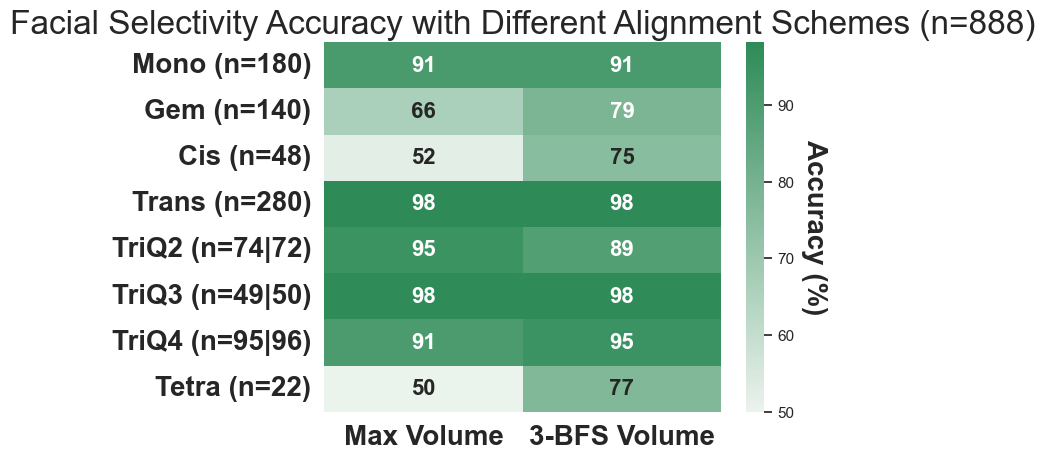

In [10]:
from seaborn import objects as so
import matplotlib.colors as mcolors
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

sns.set_theme(font='Arial')

def classify_correct(df: pd.DataFrame, alk_order:dict):
    '''
    This function finds the accuracy of the diol alignment with respect to the Sharpless mnemonic

    In the Sharpless mnemonic,
    Alpha should give bottom face dihydroxylation
    Beta should give top face dihydroxylation
    '''
    final_counts = {}

    for alk_type in alk_order:
        alk_df: pd.DataFrame = df.loc[df['Alkene Type'] == alk_type]
        total_count = len(alk_df)
        
        #Counts for alpha and beta top/bottom face addition
        alpha_df = alk_df.loc[alk_df['Catalyst Designation'] == 'Alpha']
        top_alpha_count = len(alpha_df.loc[alpha_df['Addition Face'] == 'Top'])
        bot_alpha_count = len(alpha_df.loc[alpha_df['Addition Face'] == 'Bottom'])

        beta_df = alk_df.loc[alk_df['Catalyst Designation'] == 'Beta']
        top_beta_count = len(beta_df.loc[beta_df['Addition Face'] == 'Top'])
        bot_beta_count = len(beta_df.loc[beta_df['Addition Face'] == 'Bottom'])

        #As discussed in the SI, the TriQ3 alkene/diol has an inverted mnemonic with the existing alignment scheme
        if alk_type == 'TriQ3':
            correct = top_alpha_count + bot_beta_count
            incorrect = bot_alpha_count + top_beta_count
        else:
            correct = bot_alpha_count + top_beta_count
            incorrect = top_alpha_count + bot_beta_count
        
        perc_correct = correct / total_count * 100
        perc_incorrect = incorrect / total_count * 100

        final_counts[f'{alk_type} (n={total_count})'] = (perc_correct, perc_incorrect)
    
    return final_counts

def create_binary_df(counts:dict, vol_type, count_labels):
    count_df = pd.DataFrame(
        data=counts.values(), 
        columns=[f'Correct {vol_type}', f'Incorrect {vol_type}'], 
        index=counts.keys())
    count_df['Volume'] = np.full((len(counts)),vol_type)
    fix_count = [int(x.split('(n=')[1].split(")")[0]) for x in count_labels]
    count_df[f'{vol_type} Count'] = fix_count

    return count_df

def binary_heatmap(df:pd.DataFrame, title):
    fig, ax = plt.subplots(1)
    cmap = sns.light_palette("seagreen", as_cmap=True)

    data = df[['Correct Max Volume', 'Correct 3-BFS Volume']]
    yticklabels = df.index.tolist()


    sns.heatmap(
        data=data.values,
        annot=True,
        fmt='.0f',
        cmap=cmap,
        xticklabels=['Max Volume', '3-BFS Volume'],
        yticklabels=yticklabels,
        annot_kws={"size": 16, 'weight':'bold'}
    )
    
    ax.set_ylabel("Accuracy (%)", weight='bold', fontsize=20, loc='center', rotation=270, family='Arial')

    ax.yaxis.set_label_coords(x=1.2, y=0.5)

    ax.set_title(title, fontsize=24, family='Arial')
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20, labelrotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), weight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), weight='bold')
    # ax.tick_params(axis='x', labelfontfamily='bold', labelsize=16)
    # ax.tick_params(axis='y', labelfontfamily='bold', labelsize=16, labelrotation=0)

    plt.show()

custom_order = {
    'Mono':0,
    'Gem':1,
    'Cis':2,
    'Trans':3,
    'TriQ2':4,
    'TriQ3':5,
    'TriQ4':6,
    'Tetra':7
}

#Creates a smaller 3BFSVol Dataframe and finds the accuracy 
bfs_face_df = pd.read_csv("6_2_Diol_Selectivity_3BFSVol_Desc.csv")
bfs_small_df = bfs_face_df[['Product ID', 'Catalyst Designation', 'Alkene Type', 'Addition Face']]

bfs_final_counts = classify_correct(bfs_small_df, custom_order)

#Creates a smaller MaxVol Dataframe and finds the accuracy
maxvol_face_df = pd.read_csv("6_2_Diol_Selectivity_MaxVol_Desc.csv")
maxvol_small_df = maxvol_face_df[['Product ID', 'Catalyst Designation', 'Alkene Type', 'Addition Face']]

#Isolates the indexes  of the maxvol dataframe to be equal to that of the BFSVol index for a one to one comparison
maxvol_small_df = maxvol_small_df.loc[maxvol_face_df['Product ID'].isin(bfs_small_df["Product ID"])]

maxvol_final_counts = classify_correct(maxvol_small_df, custom_order)

bfs_final_correct_perc = {k:v for k,v in zip(custom_order.keys(), bfs_final_counts.values())}
maxvol_final_correct_perc = {k:v for k,v in zip(custom_order.keys(), maxvol_final_counts.values())}

#Creates binary DF for the purposes of making a binary heatmap
bfs_df = create_binary_df(bfs_final_correct_perc, "3-BFS Volume", bfs_final_counts.keys())
max_df = create_binary_df(maxvol_final_correct_perc, "Max Volume", maxvol_final_counts.keys())

num_diols = len(bfs_face_df)

full_df = pd.concat([bfs_df,max_df],axis=1)

correct_idx = list()
for idx in full_df.index:
    ser = full_df.loc[idx]
    bfs_count = ser['3-BFS Volume Count']
    max_count = ser['Max Volume Count']
    #Corrects for changed classification for Trisubstituted alkenes
    if bfs_count != max_count:
        correct_idx.append(f'{idx} (n={max_count}|{bfs_count})')
    else:
        correct_idx.append(f'{idx} (n={bfs_count})')

full_df.index = correct_idx

binary_heatmap(full_df, f'Facial Selectivity Accuracy with Different Alignment Schemes (n={num_diols})')